# Time Series Prediction: ARMA vs LSTM
Oskar Jonsson
20021113-8375

LLM Usage:
In this problem I have used inline code suggestions from CoPilot to fix typing errors in code after writing it myself. Claude has also been used to get an understanding of the structure of the code skeleton and bug fixing. No LLM has been used for markdown boxes with discussion.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Odjej/TME286/blob/main/Assignment%201%20Time%20series%20prediction%20(black-box%20vs.%20interpretable)/ass1.ipynb)

In [1]:
# Install required packages
#%pip install -q numpy pandas matplotlib scipy statsmodels scikit-learn
#%pip install -q tensorflow keras
#%pip install -q scikit-learn
#%pip install -q matplotlib.pyplot   

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Here we implement functions for reading the files and for plotting results.

In [2]:
def read_time_series_data(training_file, validation_file, test_file):
    """
    Read time series data from three .txt files and return as pandas DataFrame.
    
    :param str training_file: Path to the training data file.
    :param str validation_file: Path to the validation data file.
    :param str test_file: Path to the test data file.
    
    :return tuple: (training_data, validation_data, test_data) where each is a pandas DataFrame.
    """
    
    training_data = pd.read_csv(training_file, header=None, names=['value'])
    validation_data = pd.read_csv(validation_file, header=None, names=['value'])
    test_data = pd.read_csv(test_file, header=None, names=['value'])
    
    return training_data, validation_data, test_data

def plot_time_series_overview(training_data, validation_data, test_data):
    """
    Plot time series data.
    
    :param pd.DataFrame training_data: DataFrame containing training data.
    :param pd.DataFrame validation_data: DataFrame containing validation data.
    :param pd.DataFrame test_data: DataFrame containing test data.
    """
    def plot_single_dataset(ax, data, title, color):
        """
        Helper function to plot a single dataset on a given axis.
    
        :param matplotlib.axes.Axes ax: The axis to plot on.
        :param pd.DataFrame data: DataFrame containing the data to plot.
        :param str title: Title for the plot.
        :param str color: Color for the plot line.
        """
        ax.plot(data.index, data['value'], color=color, linewidth=1)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)    
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Color scheme
    colors = {'training': 'blue', 'validation': 'green', 'test': 'red'}
    
    plot_single_dataset(axes[0], training_data, 'Training Data', colors['training'])   
    plot_single_dataset(axes[1], validation_data, 'Validation Data', colors['validation'])
    
    plot_single_dataset(axes[2], test_data, 'Test Data', colors['test'])
    
    plt.tight_layout()
    plt.show()
    
def plot_acf_pacf(series, lags=20, title_prefix=""):
    """
    Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series.
    
    :param pd.Series series: The time series data to analyze.
    :param int lags: The number of lags to include in the ACF and PACF plots.
    :param str title_prefix: A prefix for the plot titles to distinguish between different datasets.
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(series, lags=lags, ax=ax1)
    ax1.set_title(f'{title_prefix} Autocorrelation Function (ACF)')
    ax1.grid(True, alpha=0.3)
    
    plot_pacf(series, lags=lags, ax=ax2)
    ax2.set_title(f'{title_prefix} Partial Autocorrelation Function (PACF)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
def plot_model_predictions(test_data, predictions, model_name, rmse):
    """
    Plot test data vs model predictions.
    
    :param pd.DataFrame test_data: DataFrame containing test data.
    :param np.array predictions: Array containing model predictions for test data.
    :param str model_name: Name of the model (e.g., "ARIMA", "LSTM").
    :param float rmse: Root Mean Square Error.
    """
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(test_data.index, test_data['value'], 'b-', label='Actual Test Data', linewidth=1)
    plt.plot(test_data.index, predictions, 'r--', label=f'{model_name} Predictions', linewidth=1)
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{model_name} Model Predictions vs Actual Test Data (RMSE: {rmse:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    Plot LSTM training history (loss over epochs). 
    
    :param keras.callbacks.History history: Training history from Keras.
    """
    
    plt.figure(figsize=(12, 6))   
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Model Loss During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_comparison(test_data, arma_predictions, lstm_predictions, arma_rmse, lstm_rmse):
    """
    Plot ARMA vs LSTM predictions for comparison.
    
    :param pd.DataFrame test_data: DataFrame containing test data.
    :param np.array arma_predictions: Array containing ARMA model predictions for test data.
    :param np.array lstm_predictions: Array containing LSTM model predictions for test data.
    :param float arma_rmse: RMSE for ARMA model.
    :param float lstm_rmse: RMSE for LSTM model.
    """
    
    plt.figure(figsize=(14, 8))
    
    plt.plot(test_data.index, test_data['value'], 'k-', label='Actual Test Data', linewidth=2, alpha=0.8)
    plt.plot(test_data.index, arma_predictions, 'r--', label=f'ARMA Predictions (RMSE: {arma_rmse:.4f})', linewidth=1)
    plt.plot(test_data.index, lstm_predictions, 'g--', label=f'LSTM Predictions (RMSE: {lstm_rmse:.4f})', linewidth=1)
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Model comparison: ARMA vs LSTM')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def calculate_rmse(actual, predicted):
    """
    Calculate Root Mean Square Error.
    
    :param np.array actual: Array of actual values.
    :param np.array predicted: Array of predicted values.
    
    :return float: RMSE value.
    """
    
    return np.sqrt(mean_squared_error(actual,predicted))

def print_rmse(model_name, rmse):
    """
    Print RMSE.
    
    :param str model_name: Name of model used.
    :param float rmse: RMSE value.
    """
    
    print(f"{model_name} RMSE: {rmse:.8f}")
    

In [3]:
class ARMANelderMead:
    """
    ARMA model fitted using Nelder-Mead optimization
    """
    
    def __init__(self, p, q):
        """
        Initialize ARMA model .
        
        :param int p: Order of the AR part.
        :param int q: Order of the MA part.
        """
        
        self.p = p
        self.q = q
        self.c = None
        self.ar_params = None
        self.ma_params = None
        self.sigma2 = None
        self.residuals = None
        
        
    def _arma_likelihood(self, params, series):
        """
        Calculate negative log-likelihood.
        
        :param np.array params: Model parameters (consant, AR and MA coefficients + variance).
        :param np.array series: Time series data.
        
        :return float: Negative log-likelihood.
        """
        
        n = len(series)
        
        c = params[0]
        ar_params = params[1:1+self.p] if self.p > 0 else np.array([])
        ma_params = params[1+self.p:1+self.p+self.q] if self.q > 0 else np.array([])
        sigma2 = params[-1]
        
        # ensure sigma2 > 0
        if sigma2 <= 0:
            return np.inf
        
        # Also check for NaN or Inf in parameters
        if np.any(np.isnan(params)) or np.any(np.isinf(params)):
            return np.inf
        
        residuals = np.zeros(n)
        
        for t in range(max(self.p, self.q), n):
            # Consant
            const_part = c
            
            # AR part
            ar_part = np.sum(ar_params * series[t-np.arange(1, self.p+1)]) if self.p > 0 else 0
            
            # MA part
            ma_part = np.sum(ma_params * residuals[t-np.arange(1, self.q+1)]) if self.q > 0 and t > self.q else 0
            
            # Residual
            residuals[t] = series[t] - const_part - ar_part - ma_part
        
        # Calculate log-likelihood (assuming Gaussian errors)
        ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
        
        self.residuals = residuals
        
        return -ll
    
    def fit(self, series, max_iter=3000):
        """
        Fit ARMA modle using Nelder-Mead optimization
        
        :param np.array series: Training time series.
        :param int max_iter: Maximum number of iterations.
        """
        
        n_params = self.p + self.q + 2  # AR params + MA params + sigma2 + consant
        
        initial_params = np.zeros(n_params)
        initial_params[0] = np.mean(series)  # constant
        initial_params[1:1+self.p] = 0.1  # small initial AR coefficients
        initial_params[1+self.p:1+self.p+self.q] = 0.1  # small initial MA coefficients
        initial_params[-1] = np.var(series)  # inital variance
        
        # Bounds for parameters. Constant is unbounded, sigma2 > 0
        bounds = [(None, None)] * (n_params - 1) + [(1e-6, None)]  # all except sigma2 unbounded, sigma2 > 0
        
        # Optimize parameters using Nelder-Mead
        result = minimize(self._arma_likelihood, initial_params, args=(series.values.flatten(),), method="Nelder-Mead", bounds=bounds, tol=1e-4, options={"maxiter": max_iter, "disp": False})
        
        # Store fitted parameters
        self.c = result.x[0]  # constant is first parameter
        self.ar_params = result.x[1:1+self.p]
        self.ma_params = result.x[1+self.p:1+self.p+self.q]
        self.sigma2 = result.x[-1]
        
        # Calculate final likelihood
        self._arma_likelihood(result.x, series.values.flatten())
        
        print(f"ARMA({self.p},{self.q}) fitting completed:")
        print(f"Constant (c): {self.c:.6f}") 
        print(f"AR parameters: {self.ar_params}")
        print(f"MA parameters: {self.ma_params}")
        print(f"Sigma^2: {self.sigma2:.6f}")
        print(f"Final negative log-likelihood: {result.fun:.6f}")
        
        return self
    
    def predict(self, training_data, test_data):
        """
        Make single-step predictions.
        
        :param pd.DataFrame training_data: Training data for initialization.
        :param pd.DataFrame test_data: Test data to predict.
        
        :return np.array: Predictions.
        """
        
        full_history = training_data['value'].values.tolist()
        predictions = []
    
        # For each test point
        for i in range(len(test_data)):
            # Use current history to predict next value
            t = len(full_history)
        
            # Constant
            const_part = self.c if self.c is not None else 0
        
            # AR part 
            ar_part = 0
            if self.p > 0:
                for j in range(1, min(self.p, t) + 1):
                    ar_part += self.ar_params[j-1] * full_history[t-j]
        
            # MA part 
            ma_part = 0
            if self.q > 0 and hasattr(self, "residuals"):
                for j in range(1, min(self.q, t) + 1):
                    if t-j < len(self.residuals):
                        ma_part += self.ma_params[j-1] * self.residuals[t-j]
        
            # Prediction
            next_pred = const_part + ar_part + ma_part
            predictions.append(next_pred)
        
            full_history.append(test_data['value'].values[i])
    
        return np.array(predictions)
    
    
def find_best_arma_order(training_data, validation_data, max_p=4, max_q=4):
    """
    Find best ARMA order by minimizing RMSE on validation datas.
        
    :param pd.DataFrame training_data: Training data.
    :param pd.DataFrame validation_data: Validation data.
    :param int max_p: Maximum AR order given in problem description.
    :param int max_q: Maximum MA order given in problem description.
        
    :return tuple: (best_p, best_q, best_rmse, results_dict)
    """
        
    results = {}
    best_rmse = np.inf
    best_p, best_q = 0, 0
    best_model = None
        
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p == 0 and q == 0:
                continue  # skip ARMA(0,0) due to it being just white noise
                
            print(f"\nTrying ARMA({p},{q}):")
            try:
                # Fit
                model = ARMANelderMead(p, q)
                model.fit(training_data['value'])
                    
                val_predictions = model.predict(training_data, validation_data)
                rmse = calculate_rmse(validation_data['value'].values, val_predictions)
                
                results[(p, q)] = rmse
                
                print(f"Validation RMSE: {rmse:.8f}")
                    
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_p, best_q = p, q
                    best_model = model
                        
            except Exception as e:
                print(f"Failed: {str(e)}")
                results[(p, q)] = np.inf
                    
    print(f"Best model: ARMA({best_p},{best_q}) with validation RMSE: {best_rmse:.8f}")
    return best_p, best_q, best_rmse, results, best_model

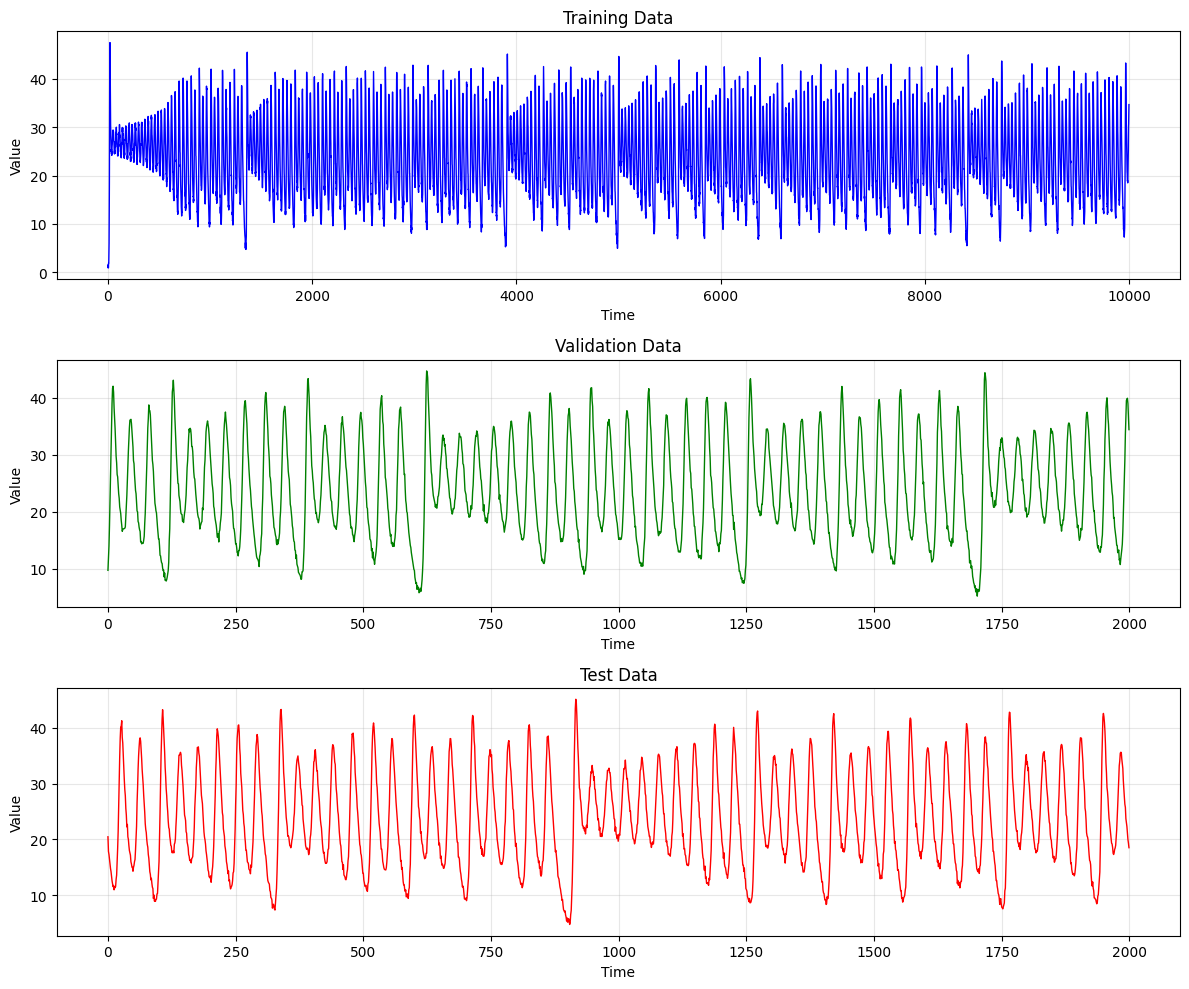

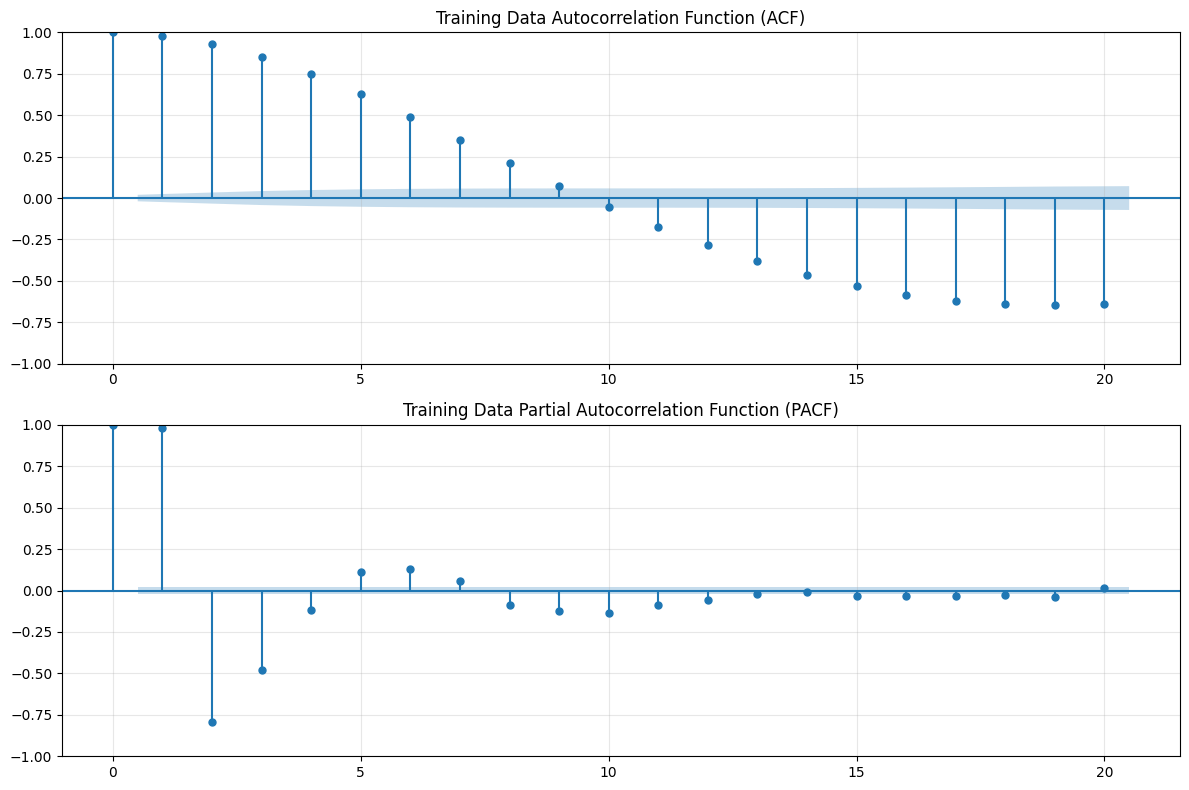


Trying ARMA(0,1):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:58: RuntimeWarning: overflow encountered in multiply
  ma_part = np.sum(ma_params * residuals[t-np.arange(1, self.q+1)]) if self.q > 0 and t > self.q else 0
C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(0,1) fitting completed:
Constant (c): 23.646696
AR parameters: []
MA parameters: [0.93468869]
Sigma^2: 21.111316
Final negative log-likelihood: 29438.424671
Validation RMSE: 8.62908672

Trying ARMA(0,2):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(0,2) fitting completed:
Constant (c): 23.608538
AR parameters: []
MA parameters: [1.46924959 0.81678234]
Sigma^2: 8.474408
Final negative log-likelihood: 24874.674360
Validation RMSE: 8.63585382

Trying ARMA(0,3):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(0,3) fitting completed:
Constant (c): 23.551615
AR parameters: []
MA parameters: [1.67663347 1.53571453 0.71124165]
Sigma^2: 4.441484
Final negative log-likelihood: 21644.346776
Validation RMSE: 8.63588095

Trying ARMA(0,4):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(0,4) fitting completed:
Constant (c): 23.469455
AR parameters: []
MA parameters: [1.70702417 1.90936355 1.40534987 0.59902748]
Sigma^2: 2.892826
Final negative log-likelihood: 19500.481944
Validation RMSE: 8.64385044

Trying ARMA(1,0):
ARMA(1,0) fitting completed:
Constant (c): 0.461641
AR parameters: [0.98063056]
MA parameters: []
Sigma^2: 2.782950
Final negative log-likelihood: 19306.925340
Validation RMSE: 1.76137002

Trying ARMA(1,1):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:58: RuntimeWarning: overflow encountered in multiply
  ma_part = np.sum(ma_params * residuals[t-np.arange(1, self.q+1)]) if self.q > 0 and t > self.q else 0


ARMA(1,1) fitting completed:
Constant (c): 0.665478
AR parameters: [0.9720121]
MA parameters: [0.52930834]
Sigma^2: 1.742821
Final negative log-likelihood: 16966.892748
Validation RMSE: 1.76402544

Trying ARMA(1,2):
ARMA(1,2) fitting completed:
Constant (c): 0.836901
AR parameters: [0.96477694]
MA parameters: [0.52051029 0.49343779]
Sigma^2: 1.287113
Final negative log-likelihood: 15451.437326
Validation RMSE: 1.76648280

Trying ARMA(1,3):
ARMA(1,3) fitting completed:
Constant (c): 0.953135
AR parameters: [0.95985546]
MA parameters: [0.39296939 0.5132695  0.4948815 ]
Sigma^2: 1.059031
Final negative log-likelihood: 14475.444027
Validation RMSE: 1.77914572

Trying ARMA(1,4):
ARMA(1,4) fitting completed:
Constant (c): 0.683642
AR parameters: [0.97108375]
MA parameters: [0.17005493 0.13527498 0.54379041 0.26482761]
Sigma^2: 1.153315
Final negative log-likelihood: 14906.837682
Validation RMSE: 1.76566627

Trying ARMA(2,0):
ARMA(2,0) fitting completed:
Constant (c): 0.822014
AR parameters: 

C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:58: RuntimeWarning: overflow encountered in multiply
  ma_part = np.sum(ma_params * residuals[t-np.arange(1, self.q+1)]) if self.q > 0 and t > self.q else 0


ARMA(2,1) fitting completed:
Constant (c): 0.772933
AR parameters: [ 1.91452919 -0.94718207]
MA parameters: [-0.44174893]
Sigma^2: 0.765680
Final negative log-likelihood: 12854.148408
Validation RMSE: 1.25668338

Trying ARMA(2,2):
ARMA(2,2) fitting completed:
Constant (c): 0.859251
AR parameters: [ 1.88601574 -0.92231689]
MA parameters: [-0.62548282  0.42357449]
Sigma^2: 0.671484
Final negative log-likelihood: 12197.998389
Validation RMSE: 1.24633793

Trying ARMA(2,3):
ARMA(2,3) fitting completed:
Constant (c): 0.880623
AR parameters: [ 1.88245742 -0.91966021]
MA parameters: [-0.66113173  0.42157517  0.05157754]
Sigma^2: 0.667159
Final negative log-likelihood: 12165.886305
Validation RMSE: 1.24330980

Trying ARMA(2,4):
ARMA(2,4) fitting completed:
Constant (c): 0.952931
AR parameters: [ 1.83799506 -0.87824693]
MA parameters: [-0.50469011  0.43641547  0.01390545  0.17157201]
Sigma^2: 0.668388
Final negative log-likelihood: 12174.126393
Validation RMSE: 1.22553713

Trying ARMA(3,0):
ARMA

C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(3,1) fitting completed:
Constant (c): 1.545628
AR parameters: [ 1.00713694  0.77152694 -0.84400794]
MA parameters: [0.04287173]
Sigma^2: 0.847341
Final negative log-likelihood: 13363.016844
Validation RMSE: 1.18268464

Trying ARMA(3,2):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(3,2) fitting completed:
Constant (c): 1.426119
AR parameters: [ 1.09440036  0.61633446 -0.77097954]
MA parameters: [ 0.30320078 -0.24748648]
Sigma^2: 0.748123
Final negative log-likelihood: 12739.000501
Validation RMSE: 1.14260578

Trying ARMA(3,3):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(3,3) fitting completed:
Constant (c): 1.962801
AR parameters: [ 0.18769748  0.95075135 -0.22204977]
MA parameters: [1.32741055 0.76527822 0.43226789]
Sigma^2: 1.154076
Final negative log-likelihood: 14901.158867
Validation RMSE: 2.62291152

Trying ARMA(3,4):
ARMA(3,4) fitting completed:
Constant (c): 1.451281
AR parameters: [ 1.03248501  0.76265552 -0.85645473]
MA parameters: [ 0.23996311 -0.322543    0.12905884 -0.12932159]
Sigma^2: 0.727287
Final negative log-likelihood: 12598.036221
Validation RMSE: 1.18570501

Trying ARMA(4,0):
ARMA(4,0) fitting completed:
Constant (c): 1.365466
AR parameters: [ 1.35244248 -0.02162325 -0.24429614 -0.14420888]
MA parameters: []
Sigma^2: 0.715881
Final negative log-likelihood: 12518.321715
Validation RMSE: 1.06731345

Trying ARMA(4,1):


C:\Users\Oskar\AppData\Local\Temp\ipykernel_5512\3304222058.py:64: RuntimeWarning: overflow encountered in square
  ll = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma2) - 0.5 * np.sum(residuals[max(self.p, self.q):]**2) / sigma2
c:\Users\Oskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ARMA(4,1) fitting completed:
Constant (c): 2.302263
AR parameters: [ 0.47298531  1.32432219 -0.46880162 -0.42585062]
MA parameters: [0.56797139]
Sigma^2: 0.858533
Final negative log-likelihood: 13425.517544
Validation RMSE: 1.40736500

Trying ARMA(4,2):
ARMA(4,2) fitting completed:
Constant (c): 2.193886
AR parameters: [ 0.80069562  0.51837403  0.10408353 -0.51587527]
MA parameters: [0.67804026 0.37640928]
Sigma^2: 0.740327
Final negative log-likelihood: 12685.856822
Validation RMSE: 1.22639845

Trying ARMA(4,3):
ARMA(4,3) fitting completed:
Constant (c): 1.245931
AR parameters: [ 1.15338617 -0.10493782  0.51071661 -0.61181143]
MA parameters: [ 0.27536671 -0.31415075 -0.78491521]
Sigma^2: 1.603757
Final negative log-likelihood: 16596.629474
Validation RMSE: 1.20561186

Trying ARMA(4,4):
ARMA(4,4) fitting completed:
Constant (c): 1.783835
AR parameters: [ 1.20204406 -0.13929239  0.42117707 -0.55930992]
MA parameters: [ 0.13667949  0.25425218 -0.22021048 -0.09322653]
Sigma^2: 0.762271
Fi

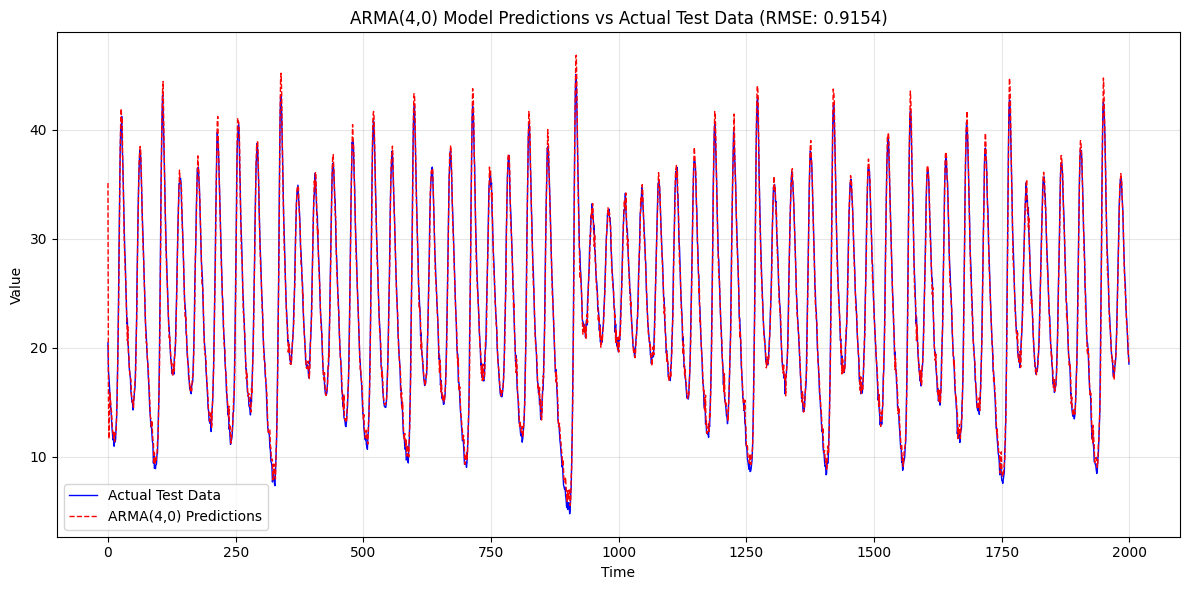

In [4]:

if __name__ == "__main__":
    # Read the data
    training_data, validation_data, test_data = read_time_series_data(
        "A1_training.txt", 
        "A1_validation.txt", 
        "A1_test.txt"
    )

    plot_time_series_overview(training_data, validation_data, test_data)
    
    plot_acf_pacf(training_data['value'], lags=20, title_prefix="Training Data")
    
    # Find best ARMA order using validation set
    best_p, best_q, best_val_rmse, results, best_model = find_best_arma_order(training_data, validation_data, max_p=4, max_q=4)
    # Make predictions on test set using best model
    test_predictions = best_model.predict(training_data, test_data)
    
    # Calculate RMSE on test set
    test_rmse = calculate_rmse(test_data['value'].values, test_predictions)
    
    print(f"\nTest set RMSE with ARMA({best_p},{best_q}): {test_rmse:.6f}")
    
    # Plot results
    plot_model_predictions(test_data, test_predictions, f"ARMA({best_p},{best_q})", test_rmse)

## Model Slection
The ACF starts at 1.0 at lag 0 and then crosses 0 and continues towards -1.0 at later lags. This is a oscillatory pattern. The PACF is like a damped oscillator with very large values early which indicates strong correlations at the first few lags. Neither function cuts off sharply suggests an ARMA model with both AR and MA compoments or a pure AR model is suitable. Large PACF values at early lags points towards AR terms of high order.

After analysis of RMSE for ARMA(p,q) it was found that ARMA(4,0) provides the lowest RMSE out of the different combinations. The model then uses the last 4 observations (AR part). This is consistent with the earlier remark of high order AR terms.

We then rerun the model fit for ARMA(4,0) with more iterations to check for convergence.

ARMA(4,0) fitting completed:
Constant (c): 1.365466
AR parameters: [ 1.35244248 -0.02162325 -0.24429614 -0.14420888]
MA parameters: []
Sigma^2: 0.715881
Final negative log-likelihood: 12518.321715

Test set RMSE with ARMA(4,0): 0.915385


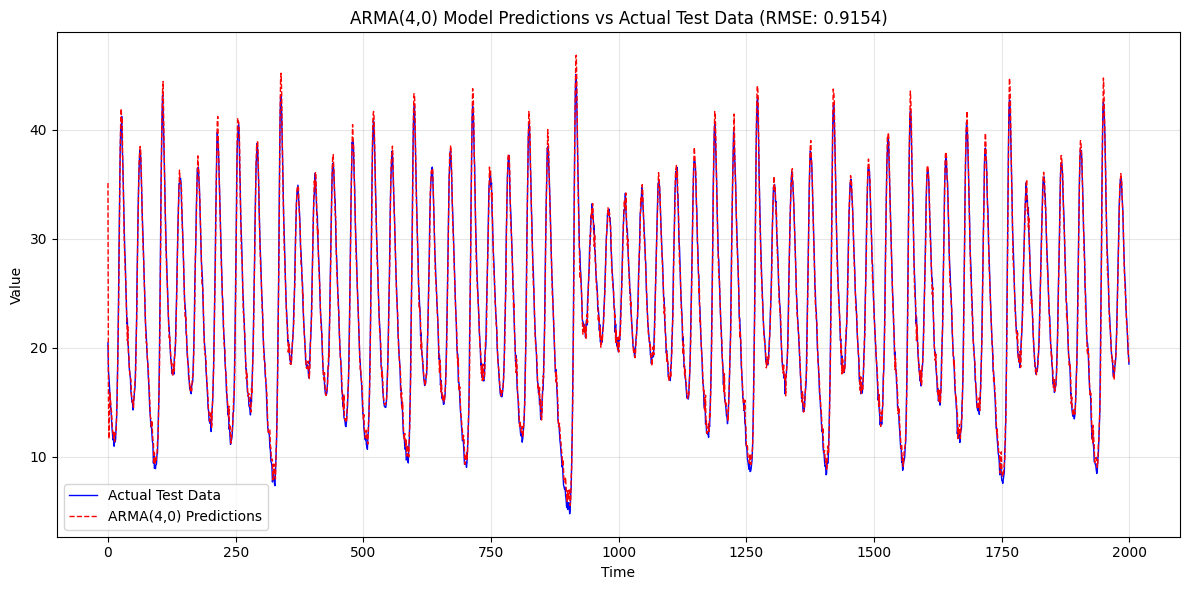

In [5]:
if __name__ == "__main__":
    # Read the data
    training_data, validation_data, test_data = read_time_series_data(
        "A1_training.txt", 
        "A1_validation.txt", 
        "A1_test.txt"
    )

    # Use ARMA(4,0)
    best_model = ARMANelderMead(4, 0)
    best_model.fit(training_data['value'], max_iter=10000)
    
    # Predict on test set
    test_predictions = best_model.predict(training_data, test_data)
    
    # Calculate RMSE
    test_rmse = calculate_rmse(test_data['value'].values, test_predictions)
    
    print(f"\nTest set RMSE with ARMA(4,0): {test_rmse:.6f}")
    
    # Plot results
    plot_model_predictions(test_data, test_predictions, f"ARMA(4,0)", test_rmse)


Constant (c): 1.365466

AR parameters: [ 1.35244248 -0.02162325 -0.24429614 -0.14420888]

MA parameters: []

Sigma^2: 0.715881

Final negative log-likelihood: 12518.321715

Test set RMSE with ARMA(4,0): 0.915385

The ARMA model is here defined with:

$X_t = c + \phi_{1}X_{t-1} +  \phi_{2}X_{t-2} +  \phi_{3}X_{t-3} +  \phi_{4}X_{t-4} + \epsilon_{t}$

With $\phi_i$ being AR parameters, $\epsilon_t$ the white noise with variance $\sigma^2$ i.e. $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ and $c$ which is a constant. Since $q=0$, there are no MA terms in the model.
 
The AR(1) coefficient $\phi_{1} = 1.48685158$ is large and positive which indicates a strong impact from the most recent observation.

$\phi_{2}$ is small and negative which indicates a mean-reverting pattern or oscillation every 2 periods which can be seen in the test data.

$\phi_{3}$ and $\phi_{4}$ are smaller in magnitude and negative which indicates weaker longer term dependencies as $X_{t-3}$ and $X_{t-4}$ are weaker.

$\sigma^2$, or the estimated noise variance, says how uncertain the prediction of the model is. A lower value means that it captures the underlying patterns better.

The constant $c$ is a baseline around which the ARMA model operates where $μ = \frac{c}{1 - ∑ \text{parameters}}$ is the mean of the data.

During forecasting, the model uses actual training values for $X_{t-1}, X_{t-2},...,$ which allows it to capture short-term oscillations that are present in the data. These are the last four values from the training set. Once it moves beyond these points, forecasts rely on previous predictions and due to the model having no MA terms the long-term trends are therefore not fully captured. The predictions there for gradually converge to the mean
\begin{equation}
μ \frac{c}{1 - ∑ \text{parameters}}
\end{equation} 

In [10]:
class LSTMTimeSeries:
    """
    Single-layer LSTM network for time series prediction with holdout validation, uses Adam optimizer with MSE loss and tanh activation
    """
    
    def __init__(self, n_units=50, seq_length=10, batch_size=32, epochs=200, patience=20):
        """
        Initialize LSTM.
        
        :param int n_units: Number of LSTM units.
        :param int seq_length: NUmber of time steps to look back.
        :param int batch_size: Batch size for training.
        :param int epochs: Maximum number of epochs.
        :param int patience: Patience for early stopping.
        """
        
        self.n_units = n_units
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.history = None
        self.best_val_loss = np.inf
        
    def _create_sequences(self, data):
        """
        Create sequences for LSTM training.
            
        :param np.array data: Scaled time series data.
            
        :return typle: (X, y) where X is input sequences and y is target values.
        """
            
        X, y = [], []
            
        for i in range(len(data)- self.seq_length):
            X.append(data[i:i + self.seq_length])
            y.append(data[i + self.seq_length])
                
        return np.array(X), np.array(y)
    
    def prepare_data(self, training_data, validation_data, test_data):
        """
        Prepare data for training with scaling.
        
        :param pd.DataFrame training_data: Training data.
        :param pd.DataFrame validation_data: Validation data.
        :param pd.DataFrame test_data: Test data.
        """
        
        self.test_indices = test_data.index[self.seq_length:].values
        
        # Extract values
        train_vals = training_data['value'].values.reshape(-1, 1)
        val_vals = validation_data['value'].values.reshape(-1, 1)
        test_vals = test_data['value'].values.reshape(-1, 1)
        
        # Store actual test values for later
        self.test_actual = test_vals[self.seq_length:].flatten()
        
        # Combine all data for scaling
        all_data = np.concatenate([train_vals, val_vals, test_vals])
        
        # Fit scaler on all data
        self.scaler.fit(all_data)
        
        # Scale each dataset
        train_scaled = self.scaler.transform(train_vals).flatten()
        val_scaled = self.scaler.transform(val_vals).flatten()
        test_scaled = self.scaler.transform(test_vals).flatten()
        
        # Create sequences
        self.X_train, self.y_train = self._create_sequences(train_scaled)
        self.X_val, self.y_val = self._create_sequences(val_scaled)
        self.X_test, self.y_test = self._create_sequences(test_scaled)
        
        # Reshape for LSTM (samples, time steps, features)
        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        self.X_val = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)
        
        print(f"\nLSTM Data prepared:")
        print(f"Training sequences: {self.X_train.shape[0]}")
        print(f"Validation sequences: {self.X_val.shape[0]}")
        print(f"Test sequences: {self.X_test.shape[0]}")
        print(f"Sequence length: {self.seq_length}")
        print(f"LSTM units: {self.n_units}")
        
    def _build_model(self):
        """
        Build single-layer LSTM with tanh activation.
        """
        
        model = Sequential([
        Input(shape=(self.seq_length, 1)),  
        LSTM(self.n_units, activation="tanh"),
        Dense(1)
        ])
        
        model.compile(optimizer="adam", loss="mse")
        
        return model
        
    def fit(self, verbose=0):
        """
        Train LSTM model with early stopping based on validation loss, store network with smallest loss.
        
        :param int verbose: Verbosity level.
        """
        
        self.model = self._build_model()
        
        early_stopping = EarlyStopping(monitor="val_loss", patience=self.patience, restore_best_weights=True, verbose=verbose)
        
        checkpoint = ModelCheckpoint("best_lstm_model.keras", monitor="val_loss", save_best_only=True, verbose=verbose)
        
        # Train model
        self.history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping, checkpoint],
            verbose=verbose
        )
        
        # Load the best model
        if os.path.exists('best_lstm_model.keras'):
            self.model.load_weights('best_lstm_model.keras')
            self.best_val_loss = min(self.history.history['val_loss'])
            
        print(f"\nLSTM Training completed:")
        print(f"Best validation loss: {self.best_val_loss:.6f}")
        print(f"Final training loss: {self.history.history['loss'][-1]:.6f}")
        print(f"Stopped at epoch: {len(self.history.history['loss'])}")
        
        return self
    
    def predict(self):
        """
        Make predictions on the test set.
        
        :return np.array: Predictions in original scale.
        """
        
        # Predict on test set
        predictions_scaled = self.model.predict(self.X_test, verbose=0).flatten()
        
        # Inverse transform to original scale
        predictions = self.scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
        
        return predictions
    
    def get_test_rmse(self):
        """
        Calculate RMSE on test set.
        
        :return float: RMSE.
        """
        
        predictions = self.predict()
        rmse = calculate_rmse(self.test_actual, predictions)
        return rmse
    
    def plot_training_history(self):
        """
        Plot training history with existing function.
        """
        
        if self.history:
            plot_training_history(self.history)
            
    def plot_predictions(self):
        """
        Plot predictions with existing function.
        """
        
        predictions = self.predict()
        rmse = self.get_test_rmse()
        plot_model_predictions(
            pd.DataFrame({'value': self.test_actual}, index=self.test_indices),
            predictions,
            f"LSTM ({self.n_units} units)",
            rmse
        )
         

In [11]:
class LSTMExperiment:
    """
    Class for running LSTM experiments with different configurations.
    """
    def __init__(self, training_data, validation_data, test_data):
        """
        Initialize experiment with data.
        
        :param pd.DataFrame training_data: Training data.
        :param pd.DataFrame validation_data: Validation data.
        :param pd.DataFrame test_data: Test data.
        """
        self.training_data = training_data
        self.validation_data = validation_data
        self.test_data = test_data
        self.results = {}
        self.best_model = None
        self.best_n_units = None
        self.best_rmse = np.inf
        self.best_seq_length = None
        
    def run_experiments(self, units_list=[20, 50, 100, 200], seq_length=10, verbose=0):
        """
        Run experiments with different numbers of LSTM units.
        
        :param list units_list: List of LSTM units to try.
        :param int seq_length: Sequence length to use.
        :param int verbose: Verbosity level.
        """
        
        for n_units in units_list:
            print(f"\n{'-'*50}")
            print(f"Testing LSTM with {n_units} units...")
            print(f"{'-'*50}")
            
            try:
                # Create and train model
                model = LSTMTimeSeries(n_units=n_units, seq_length=seq_length)
                model.prepare_data(self.training_data, self.validation_data, self.test_data)
                model.fit(verbose=verbose)
                
                # Calculate test RMSE
                test_rmse = model.get_test_rmse()
                
                # Store results
                self.results[(n_units, seq_length)] = {
                    'model': model,
                    'test_rmse': test_rmse,
                    'best_val_loss': model.best_val_loss,
                    'n_units': n_units,
                    'seq_length': seq_length
                }
                
                print(f"Test RMSE: {test_rmse:.4f}")
                print(f"Best validation loss: {model.best_val_loss:.6f}")
                
                # Track best model
                if test_rmse < self.best_rmse:
                    self.best_rmse = test_rmse
                    self.best_model = model
                    self.best_n_units = n_units
                    self.best_seq_length = seq_length
                    
            except Exception as e:
                print(f"Failed: {str(e)}")
        
        return self.results
    
    def run_all_experiments(self, units_list=[20, 50, 100, 200], seq_lengths=[5, 10, 20], verbose=0):
        """
        Run experiments with different units and sequence lengths.
        
        :param list units_list: List of LSTM units to try.
        :param list seq_lengths: List of sequence lengths to try.
        :param int verbose: Verbosity level.
        """
        
        for seq_length in seq_lengths:
            self.run_experiments(units_list=units_list, seq_length=seq_length, verbose=verbose)
        
        self.print_summary()
        
        return self.results
    
    def print_summary(self):
        """
        Print summary of all experiments.
        """
        
        print("\n" + "="*70)
        print("EXPERIMENT SUMMARY")
        print("="*70)
        print(f"\n{'Units':<8} {'Seq Len':<10} {'Test RMSE':<12} {'Best Val Loss':<15}")
        print("-"*50)
        
        for (n_units, seq_length), result in self.results.items():
            print(f"{n_units:<8} {seq_length:<10} {result['test_rmse']:<12.4f} {result['best_val_loss']:<15.6f}")
        
        print("\n" + "="*70)
        print(f"BEST MODEL: {self.best_n_units} units with seq_length={self.best_seq_length}")
        print(f"BEST TEST RMSE: {self.best_rmse:.4f}")
        print("="*70)
        
    def plot_best_model_results(self):
        """
        Plot results for the best model.
        """
        if self.best_model:
            print(f"\nPlotting best model ({self.best_n_units} units, seq_length={self.best_seq_length})")
            self.best_model.plot_training_history()
            self.best_model.plot_predictions()
            
    def plot_all_comparisons(self):
        """
        Plot all test predictions for comparison.
        """
        plt.figure(figsize=(14, 8))
        
        # Plot actual test data
        plt.plot(self.test_data.index, self.test_data['value'], 
                'k-', label='Actual Test Data', linewidth=2, alpha=0.8)
        
        # Plot each model's predictions
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.results)))
        for idx, ((n_units, seq_length), result) in enumerate(self.results.items()):
            predictions = result['model'].predict()
            rmse = result['test_rmse']
            plt.plot(self.test_data.index[result['model'].seq_length:], predictions,
                    color=colors[idx], linestyle='--', alpha=0.7, linewidth=1,
                    label=f'LSTM({n_units}, seq={seq_length}) RMSE: {rmse:.3f}')
        
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('LSTM Model Comparison: All Configurations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        


--------------------------------------------------
Testing LSTM with 20 units...
--------------------------------------------------

LSTM Data prepared:
Training sequences: 9995
Validation sequences: 1995
Test sequences: 1995
Sequence length: 5
LSTM units: 20

LSTM Training completed:
Best validation loss: 0.000649
Final training loss: 0.000679
Stopped at epoch: 80
Test RMSE: 0.5948
Best validation loss: 0.000649

--------------------------------------------------
Testing LSTM with 50 units...
--------------------------------------------------

LSTM Data prepared:
Training sequences: 9995
Validation sequences: 1995
Test sequences: 1995
Sequence length: 5
LSTM units: 50

LSTM Training completed:
Best validation loss: 0.000657
Final training loss: 0.000702
Stopped at epoch: 62
Test RMSE: 0.5974
Best validation loss: 0.000657

--------------------------------------------------
Testing LSTM with 100 units...
--------------------------------------------------

LSTM Data prepared:
Training 

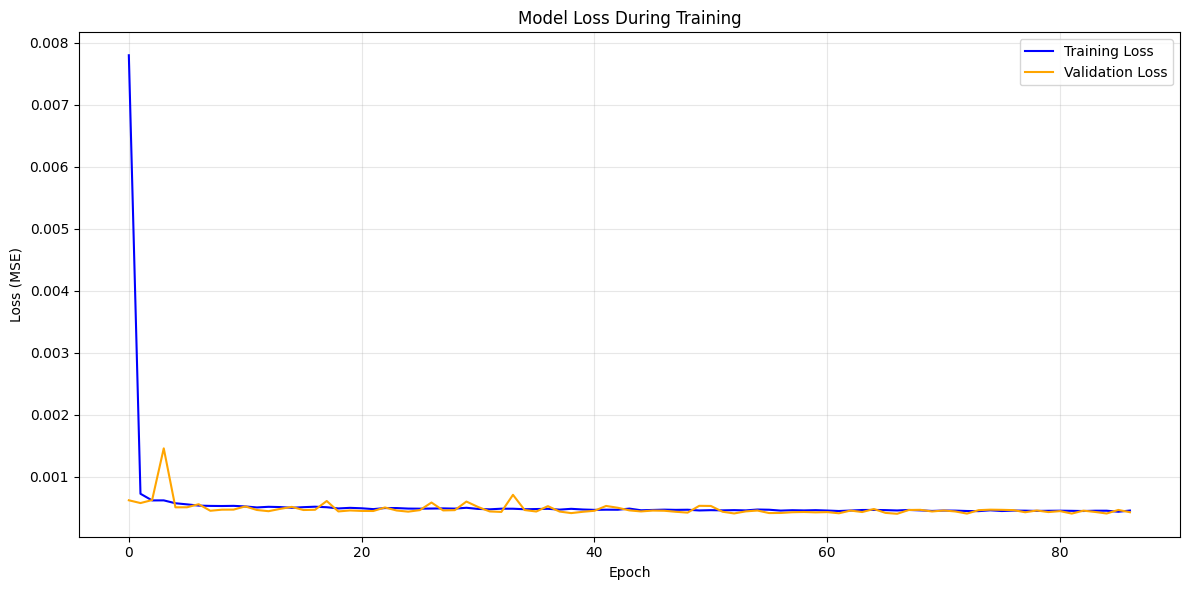

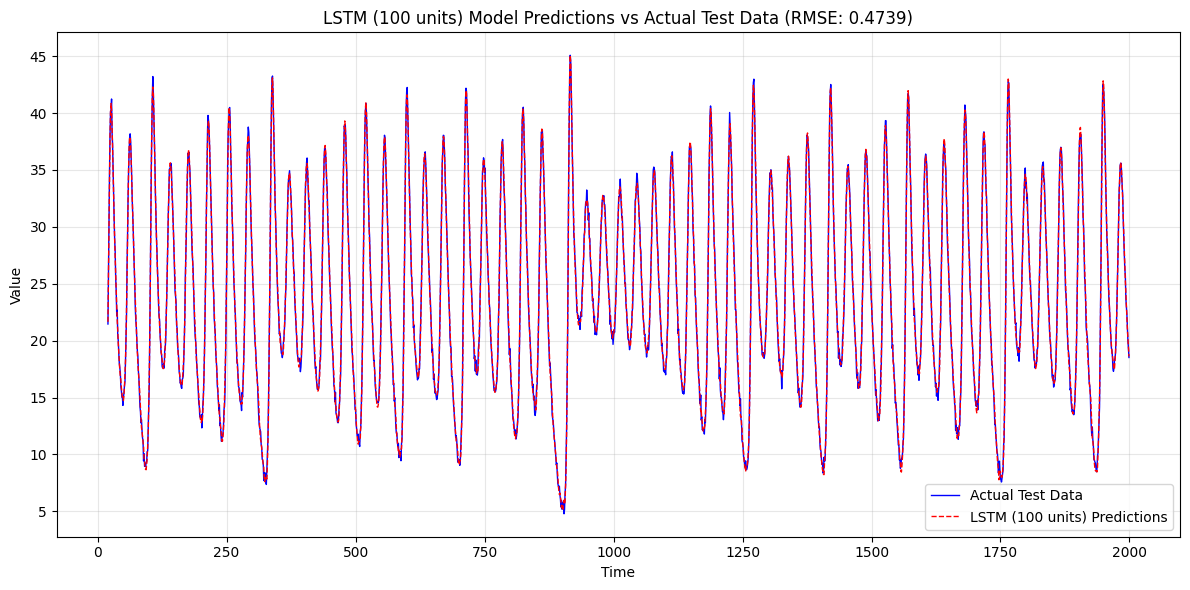

In [13]:
if __name__ == "__main__":
    training_data, validation_data, test_data = read_time_series_data(
        "A1_training.txt", 
        "A1_validation.txt", 
        "A1_test.txt"
    )
    
    # Create experiment
    experiment = LSTMExperiment(training_data, validation_data, test_data)
    
    # Run experiments with different units and sequence lengths
    results = experiment.run_all_experiments(
        units_list=[20, 50, 100, 200],
        seq_lengths=[5, 10, 20],
        verbose=0
    )
    
    # Plot results for best model
    experiment.plot_best_model_results()

# LSTM discussion

The results above show that this series has long-range dependencies as looking back 20 time steps yields more accurate results than just looking back 5 time steps. The number of units show diminishing returns after 100. 20-50 performs similarly while 200 units perform slightly worse which might be due to overfitting. We have a very 